In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras import*
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/Shareddrives/huy/core/kvasir-dataset-v2.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: kvasir-dataset-v2/normal-pylorus/79b990c2-870b-4cdd-8d8d-ad7ea33e0258.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/af744492-dc36-4f70-95e8-9056c462eaca.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/7f607ea9-1c1a-4e65-9888-7db35c807f59.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/c777b21e-9dc0-4179-a849-455044cb0d2c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/9a824235-7dda-494b-8213-a1185ac7d7ab.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/b9559ef9-163d-4d98-a8d4-5f058bfa8003.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/3f429284-8727-43df-800a-6bfc84e71cc2.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/dabd496e-b1b0-4c25-aebb-a65a8fe4739c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/5c1e245c-c69e-42e5-a5b3-fcfba78b667f.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/32b4ac97-2c27-4059-aa53-c304fdc2cc50.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/1d9233e

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 686kB 26.1MB/s 


In [ ]:
train_dir ="/content/kvasir-dataset-v2"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                                    batch_size = 32,
                                                                    image_size = (256,256),
                                                                    shuffle = True, 
                                                                    seed = 505,
                                                                    validation_split=0.25,
                                                                    subset = "training")
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                                    batch_size = 32,
                                                                    image_size = (256,256),
                                                                    shuffle = True, 
                                                                    seed = 505,
                                                                    validation_split=0.25,
                                                                    subset = "validation")

Found 8000 files belonging to 8 classes.
Using 6000 files for training.
Found 8000 files belonging to 8 classes.
Using 2000 files for validation.


In [ ]:
IMG_SHAPE =(256,256,3)
model1 = tf.keras.applications.ResNet101(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

171450368/171446536 [==============================] - 4s 0us/step


In [ ]:
model2 = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

29089792/29084464 [==============================] - 1s 0us/step


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
prediction_layer = tf.keras.layers.Dense(8)

In [ ]:
model1.trainable= False
model2.trainable= False

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3))
data = data_augmentation(inputs)
data= preprocess_input(data)
data = rescale(data)
x = model1(data,training = False)
y = model2(data,training = False)
x = Conv2D(1024,kernel_size=(3,3),strides = (1,1),padding = 'same')(x)
merge = Add()([x,y])
merge = global_average_layer(merge)
merge = tf.keras.layers.Dropout(0.5)(merge)
outputs = prediction_layer(merge)
model = tf.keras.Model(inputs, outputs)

In [ ]:
import numpy as np
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

4

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = '/content/checkpoint', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset, callbacks= [checkpoint])
model.save('res_dense.h5')

Epoch 1/10
188/188 [==============================] - 96s 357ms/step - loss: 2.2472 - accuracy: 0.3018 - val_loss: 1.9141 - val_accuracy: 0.3635

Epoch 00001: val_loss improved from inf to 1.91415, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 2/10
188/188 [==============================] - 63s 329ms/step - loss: 1.7847 - accuracy: 0.3990 - val_loss: 1.2786 - val_accuracy: 0.4990

Epoch 00002: val_loss improved from 1.91415 to 1.27863, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 3/10
188/188 [==============================] - 59s 307ms/step - loss: 1.5874 - accuracy: 0.4583 - val_loss: 1.2913 - val_accuracy: 0.5030

Epoch 00003: val_loss did not improve from 1.27863
Epoch 4/10
188/188 [==============================] - 59s 307ms/step - loss: 1.3932 - accuracy: 0.4945 - val_loss: 1.3260 - val_accuracy: 0.5030

Epoch 00004: val_loss did not improve from 1.27863
Epoch 5/10
188/188 [==============================] - 58s 303ms/step - loss: 1.3479 - accuracy: 0.5183 - val_loss: 1.3685 - val_accuracy: 0.5270

Epoch 00005: val_loss did not improve from 1.27863
Epoch 6/10
188/188 [==============================] - 58s 303ms/step - loss: 1.2337 - accuracy: 0.5553 - val_loss: 1.0389 - val_accuracy: 0.6295

Epoch 00006: val_loss improved from 1.27863 to 1.03887, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 7/10
188/188 [==============================] - 59s 308ms/step - loss: 1.2484 - accuracy: 0.5513 - val_loss: 0.9140 - val_accuracy: 0.6440

Epoch 00007: val_loss improved from 1.03887 to 0.91398, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 8/10
188/188 [==============================] - 59s 307ms/step - loss: 1.1412 - accuracy: 0.5850 - val_loss: 1.0080 - val_accuracy: 0.6195

Epoch 00008: val_loss did not improve from 0.91398
Epoch 9/10
188/188 [==============================] - 59s 307ms/step - loss: 1.0356 - accuracy: 0.6218 - val_loss: 0.9379 - val_accuracy: 0.6435

Epoch 00009: val_loss did not improve from 0.91398
Epoch 10/10
188/188 [==============================] - 59s 305ms/step - loss: 0.9862 - accuracy: 0.6230 - val_loss: 0.8378 - val_accuracy: 0.6775

Epoch 00010: val_loss improved from 0.91398 to 0.83778, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets


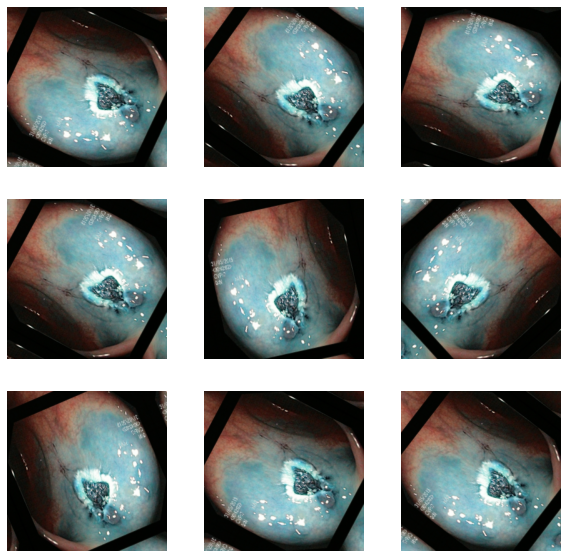

In [ ]:
import matplotlib.pyplot as plt
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

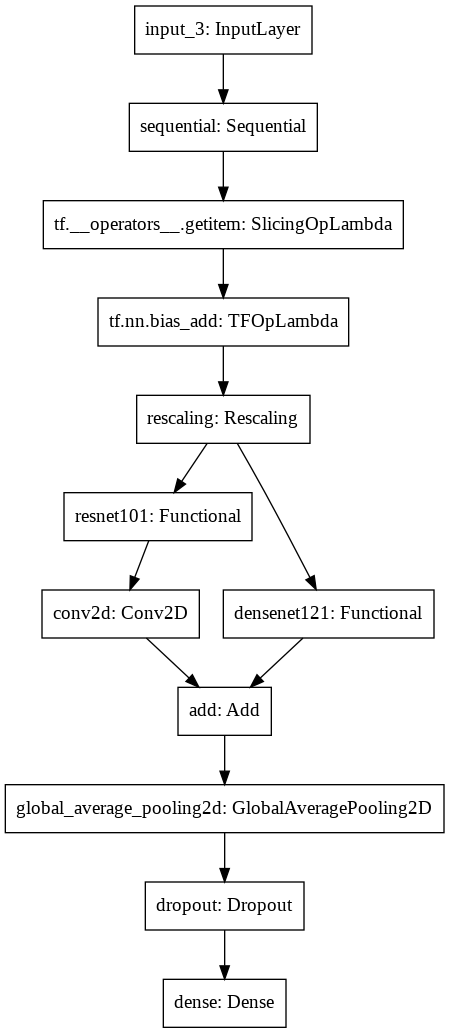

In [ ]:
tf.keras.utils.plot_model(model)

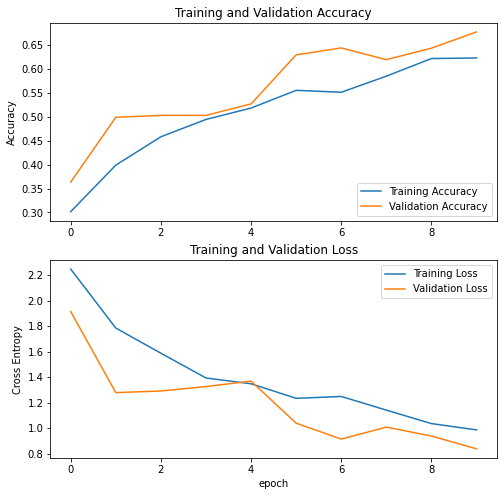

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model1.trainable=True
model2.trainable= True
model.trainable= True

In [ ]:
print("Number of layers in the base model: ", len(model1.layers))

Number of layers in the base model:  345


In [ ]:
fine_tune_at = 100
for layer in model1.layers[:fine_tune_at]:
  layer.trainable =  False
for layer in model2.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset, callbacks= [checkpoint])
# model.save('res_dense_after.h5')

Epoch 1/10
188/188 [==============================] - 118s 426ms/step - loss: 0.7425 - accuracy: 0.7212 - val_loss: 0.7286 - val_accuracy: 0.7250

Epoch 00001: val_loss improved from 0.83778 to 0.72857, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 2/10
188/188 [==============================] - 78s 408ms/step - loss: 0.4722 - accuracy: 0.8178 - val_loss: 0.3904 - val_accuracy: 0.8490

Epoch 00002: val_loss improved from 0.72857 to 0.39041, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 3/10
188/188 [==============================] - 78s 408ms/step - loss: 0.3636 - accuracy: 0.8603 - val_loss: 0.3367 - val_accuracy: 0.8615

Epoch 00003: val_loss improved from 0.39041 to 0.33671, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 4/10
188/188 [==============================] - 78s 408ms/step - loss: 0.3261 - accuracy: 0.8702 - val_loss: 0.3169 - val_accuracy: 0.8765

Epoch 00004: val_loss improved from 0.33671 to 0.31694, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 5/10
188/188 [==============================] - 78s 407ms/step - loss: 0.2867 - accuracy: 0.8902 - val_loss: 0.2952 - val_accuracy: 0.8920

Epoch 00005: val_loss improved from 0.31694 to 0.29522, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 6/10
188/188 [==============================] - 78s 406ms/step - loss: 0.2641 - accuracy: 0.8977 - val_loss: 0.2687 - val_accuracy: 0.9060

Epoch 00006: val_loss improved from 0.29522 to 0.26870, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 7/10
188/188 [==============================] - 78s 406ms/step - loss: 0.2432 - accuracy: 0.9065 - val_loss: 0.2630 - val_accuracy: 0.8940

Epoch 00007: val_loss improved from 0.26870 to 0.26301, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 8/10
188/188 [==============================] - 78s 406ms/step - loss: 0.2293 - accuracy: 0.9088 - val_loss: 0.2625 - val_accuracy: 0.9055

Epoch 00008: val_loss improved from 0.26301 to 0.26251, saving model to /content/checkpoint


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/checkpoint/assets
Epoch 9/10
188/188 [==============================] - 77s 404ms/step - loss: 0.2241 - accuracy: 0.9098 - val_loss: 0.3319 - val_accuracy: 0.8870

Epoch 00009: val_loss did not improve from 0.26251
Epoch 10/10
188/188 [==============================] - 78s 406ms/step - loss: 0.2156 - accuracy: 0.9148 - val_loss: 0.2761 - val_accuracy: 0.9020

Epoch 00010: val_loss did not improve from 0.26251


In [ ]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

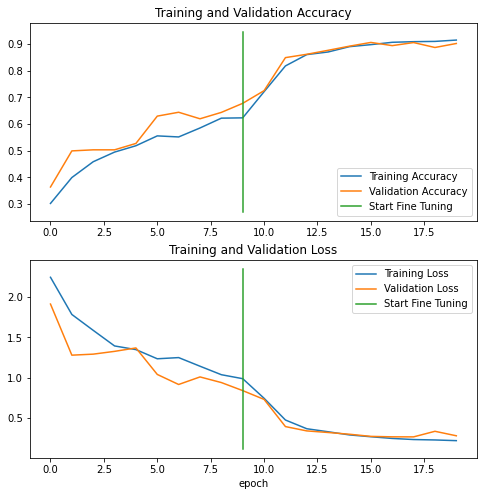

In [ ]:
initial_epochs=10
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
!unzip /content/drive/Shareddrives/huy/core/kvasir-dataset.zip

Archive:  /content/drive/Shareddrives/huy/core/kvasir-dataset.zip
   creating: kvasir-dataset/
   creating: kvasir-dataset/polyps/
  inflating: kvasir-dataset/polyps/896dccb7-7df2-4c6d-9c75-9c201a70eb22.jpg  
  inflating: kvasir-dataset/polyps/89530f9a-3694-4dd0-b51a-b8d936b1f411.jpg  
  inflating: kvasir-dataset/polyps/69a27f9e-e92d-4054-adaa-405eeace8b2a.jpg  
  inflating: kvasir-dataset/polyps/9f997a2b-7c3a-422a-8dc6-2e6e87ca45a6.jpg  
  inflating: kvasir-dataset/polyps/d9a0874a-990a-4bc6-9e42-62e2b6e65381.jpg  
  inflating: kvasir-dataset/polyps/1c236874-556c-402d-9709-c5c1672ec14a.jpg  
  inflating: kvasir-dataset/polyps/0c1b433f-75b4-4dc0-8ea0-2eaac21593a7.jpg  
  inflating: kvasir-dataset/polyps/30058222-dbb6-40c4-b466-7a4e1d7e098c.jpg  
  inflating: kvasir-dataset/polyps/3a294535-a9d2-4d0f-b98f-0f4d7e5bb1fd.jpg  
  inflating: kvasir-dataset/polyps/b3a01269-1dc6-43a0-9d5e-1861db87d8be.jpg  
  inflating: kvasir-dataset/polyps/2a2edeab-7a81-44ce-a57f-342b8acbac4c.jpg  
  inflating

In [ ]:
test_dir = "/content/kvasir-dataset/"
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                    batch_size = 32,
                                                                    image_size = (256,256),
                                                                    shuffle = False, 
                                                                    seed = 505,)

Found 4000 files belonging to 8 classes.


In [ ]:
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
model.evaluate(test_dataset)

125/125 [==============================] - 31s 234ms/step - loss: 0.2092 - accuracy: 0.9262


[0.20916420221328735, 0.9262499809265137]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1. / 127.5)
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(256, 256),
                                                        batch_size=128,
                                                        class_mode='categorical')

Found 4000 images belonging to 8 classes.


In [ ]:
Y_pred = model.predict(test_dataset)
# y_pred = np.argmax(Y_pred)
# y_pred = np.rint(Y_pred)


In [ ]:
print(Y_pred)

[[ 8.708624    1.7854962  -3.3974032  ... -3.4558733  -0.74564844
  -2.0423152 ]
 [ 9.026807    6.931248   -3.3865454  ... -4.722736   -2.9739316
  -2.7292347 ]
 [ 9.455418    4.0472474  -0.64654744 ... -2.0760071  -1.4712198
  -3.1164012 ]
 ...
 [-2.8992383  -3.7105558  -1.1693946  ... -2.4651234   1.7217073
  10.677271  ]
 [-3.8549576  -3.9891472  -0.87604517 ... -3.685562    2.3057532
  10.280768  ]
 [-1.8983968  -2.189596   -1.7647643  ... -1.5074868  -0.25785878
   7.647837  ]]


In [ ]:
import numpy as np
y_pred = np.argmax(Y_pred,axis=-1)

In [ ]:
y_true = test_data.classes
print(y_true)

[0 0 0 ... 7 7 7]


In [ ]:
test_dataset.classes

AttributeError: ignored

In [ ]:
print(y_pred.shape)

(4000,)


In [ ]:
print(y_pred)

[0 0 0 ... 7 7 7]


              precision    recall  f1-score   support

           0       0.98      0.82      0.89       500
           1       0.85      0.98      0.91       500
           2       0.96      0.76      0.85       500
           3       0.96      0.98      0.97       500
           4       0.98      0.99      0.99       500
           5       0.80      0.97      0.88       500
           6       0.97      0.94      0.95       500
           7       0.97      0.97      0.97       500

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



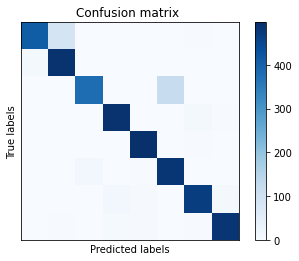

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
# cm = metrics.multilabel_confusion_matrix(test_data.classes, y_pred)
print(metrics.classification_report(test_data.classes,y_pred))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()
# print(metrics.classification_report(y_true,y_pred))

In [ ]:
 cm = metrics.confusion_matrix(test_data.classes, y_pred)
 print(cm)
 print(metrics.classification_report(test_data.classes,y_pred))

[[410  87   0   0   0   0   3   0]
 [  9 491   0   0   0   0   0   0]
 [  0   0 379   0   1 120   0   0]
 [  0   0   0 490   0   0   8   2]
 [  0   0   0   0 497   1   2   0]
 [  0   0  13   0   2 485   0   0]
 [  1   0   1  13   5   0 469  11]
 [  0   3   1   6   4   0   2 484]]
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       500
           1       0.85      0.98      0.91       500
           2       0.96      0.76      0.85       500
           3       0.96      0.98      0.97       500
           4       0.98      0.99      0.99       500
           5       0.80      0.97      0.88       500
           6       0.97      0.94      0.95       500
           7       0.97      0.97      0.97       500

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



In [ ]:
print(cm.shape)

(8, 2, 2)


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix on Kvasir V1',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

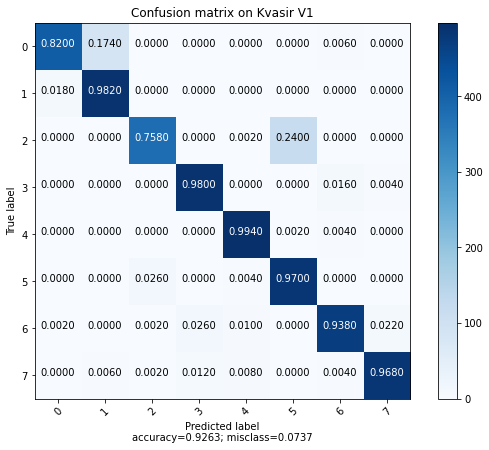

In [ ]:
plot_confusion_matrix(cm,[0,1,2,3,4,5,6,7])

In [ ]:
print(f1_m(test_data.classes,y_pred))

In [ ]:
from sklearn.metrics import recall,precision
recall_score(y_true=y_true, y_pred=y_pred, average='weighted')

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 13.0MB/s 


In [ ]:
import tensorflow_addons as tfa

In [ ]:
print(test_data.classes)

[0 0 0 ... 7 7 7]


In [ ]:
print(y_pred)

[7 3 0 ... 3 7 6]


In [ ]:
import sklearn